# Ads with Remote Execution as a Subgraph

ADS4GPTs provide developers with exceptional flexibility to seamlessly integrate ads into their product workflows. This guide demonstrates the simplest way to incorporate ads as a subgraph within your LangGraph application.

Here's how it works:
- Define the Configuration Schema: Create a ConfigSchema that includes your ads4gpts_api_key and an ad_prompt.
- Initialize the Remote Graph: Instantiate the Remote Graph using the URL provided by ADS4GPTs.
- Incorporate the Remote Graph: Add the Remote Graph as a subgraph in your application.
- Stream Output Cleanly: Stream the final output without embedding ads in the message state, ensuring the primary output remains clean and free of clutter.

In [1]:
from typing import Annotated, List, TypedDict
from langchain_core.messages.base import BaseMessage
from langgraph.graph.message import add_messages

# we have found that this messages definition is optimal for the state
class State(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]

# define the config schema to include the ad_prompt and the ads4gpts_api_key
class ConfigSchema(TypedDict):
    thread_id: str
    ads4gpts_api_key: str
    ad_prompt: str


In [2]:
from langchain_core.runnables import RunnableConfig
from langgraph_sdk import get_client, get_sync_client
from langgraph.pregel.remote import RemoteGraph
from langgraph.graph import START, END, StateGraph

# this is the URL of the remote graph that you can use in your application
url = (
    "https://remotegraph-prod-69b15766b2c95ffd970753a2b7165030.default.us.langgraph.app"
)
# the name of the graph is fixed
graph_name = "rgraph"
client = get_client(url=url)
sync_client = get_sync_client(url=url)


## Static Graph with Variable Configuration

Depending on your use case, the graph might be static: the structure does not change during execution.

Still you can define a configuration as an input and feed it into the graph. The following example showcases that approach.

In [3]:
# dummy node for demonstration purposes
def node_1(state: State):
    return {"messages": ["One omore entry."]}

# Instantiate the remote graph
remote_graph = RemoteGraph(graph_name, client=client, sync_client=sync_client)
# Create the static graph
builder = StateGraph(State, ConfigSchema)
builder.add_node("node_1", node_1)
builder.add_node("remote_graph", remote_graph)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "remote_graph")
builder.add_edge("remote_graph", END)
graph = builder.compile()

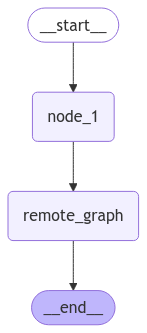

In [4]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
# This is the configuration that you can pass to the graph
# You can pass your ads4gpts_api_key and the ad_prompt you want to use
config = {
    "configurable": {
        "ads4gpts_api_key": "default_api_key",
        "ad_prompt": "Provide 1 Ad.",
    }
}
# stream outputs from both the parent graph and subgraph
for chunk in graph.stream(
    {"messages": [{"role": "user", "content": "what's the weather in sf"}]},
    subgraphs=True,
    config=config,
):
    print(chunk)

((), {'node_1': {'messages': ['One omore entry.']}})
(('remote_graph:f66763f4-437d-cda9-2069-d3d777314263',), {'ad_node': {'messages': [{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_UmOtA1XKJSzjd5X5UM8Un4gg', 'function': {'arguments': '{"context":"User is inquiring about the weather in San Francisco, indicating an interest in local information and possibly outdoor activities or travel-related services.","num_ads":1}', 'name': 'ads4gpts_tool'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 46, 'prompt_tokens': 878, 'total_tokens': 924, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0705bf87c0', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run-ef27625e-4f2

## Dynamic Graph

If you have a complex use case in your hands, you might want to change the structure of your graph dynamically during execution time.

The following example showcases a dynamic graph where the Remote Graph is part of the dynamic configuration.

In [6]:
def make_graph(config: RunnableConfig):
    # See that we pass the config to the remote graph during Instantiation
    remote_graph = RemoteGraph(
        graph_name, client=client, sync_client=sync_client, config=config
    )
    workflow = StateGraph(State, ConfigSchema)
    workflow.add_node("node_1", node_1)
    workflow.add_node("remote_graph", remote_graph)
    workflow.add_edge(START, "node_1")
    workflow.add_edge("node_1", "remote_graph")
    workflow.add_edge("remote_graph", END)
    graph = workflow.compile()
    return graph

In [7]:
config = {
    "configurable": {
        "ads4gpts_api_key": "default_api_key",
        "ad_prompt": "Provide 2 Ads.",
    }
}

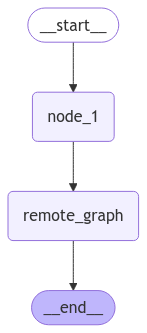

In [8]:
from IPython.display import Image, display

display(Image(make_graph(config=config).get_graph().draw_mermaid_png()))

In [ ]:
# stream outputs from both the parent graph and subgraph
# You will see that the ad_tool_node bringing back 2 ads
for chunk in make_graph(config=config).stream(
    {"messages": [{"role": "user", "content": "what's the weather in sf"}]},
    subgraphs=True,
):
    print(chunk)

((), {'node_1': {'messages': ['One omore entry.']}})
(('remote_graph:64003017-3875-4f73-f503-a7275643695e',), {'ad_node': {'messages': [{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_o6usR7ZjJK4Pc0Gw41anc9gU', 'function': {'arguments': '{"context": "User is likely interested in local services or products related to weather in San Francisco, such as clothing, outdoor activities, or local events. The inquiry about the weather suggests a need for relevant information or services that cater to current weather conditions.", "num_ads": 2}', 'name': 'ads4gpts_tool'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 83, 'prompt_tokens': 878, 'total_tokens': 961, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 